<a href="https://colab.research.google.com/github/goodycloud/ai_lab/blob/main/20251119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


In [ ]:
# Load California Housing dataset
data = fetch_california_housing()

# Extract features and target
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data.feature_names}")
print(f"Target: Median house value (in $100,000s)")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min() * 100000:.2f}")
print(f"  Max: ${y.max() * 100000:.2f}")
print(f"  Mean: ${y.mean() * 100000:.2f}")

Dataset Information:
Number of samples: 20640
Number of features: 8

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)

Target statistics:
  Min: $14999.00
  Max: $500001.00
  Mean: $206855.82


In [ ]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 16512 samples
Test set size: 4128 samples

✓ Data normalized (mean=0, std=1)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 258
Number of test batches: 65


In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


In [ ]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


In [ ]:
# Training parameters
num_epochs = 100

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 0.3203 | Test Loss: 0.3235
Epoch [20/100] | Train Loss: 0.2904 | Test Loss: 0.3036
Epoch [30/100] | Train Loss: 0.2752 | Test Loss: 0.3040
Epoch [40/100] | Train Loss: 0.2681 | Test Loss: 0.2858
Epoch [50/100] | Train Loss: 0.2598 | Test Loss: 0.2819
Epoch [60/100] | Train Loss: 0.2544 | Test Loss: 0.2866
Epoch [70/100] | Train Loss: 0.2516 | Test Loss: 0.2816
Epoch [80/100] | Train Loss: 0.2454 | Test Loss: 0.2720
Epoch [90/100] | Train Loss: 0.2426 | Test Loss: 0.2804
Epoch [100/100] | Train Loss: 0.2378 | Test Loss: 0.2728
------------------------------------------------------------
Training complete!


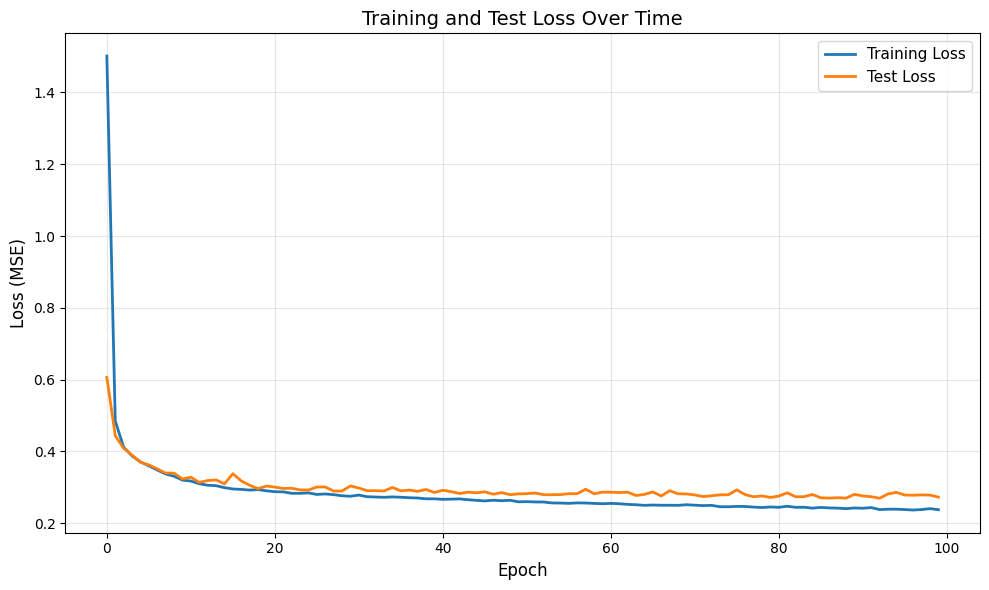

Final Training Loss: 0.2378
Final Test Loss: 0.2728


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [ ]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  0.2733
Root Mean Squared Error (RMSE): 0.5227
Mean Absolute Error (MAE): 0.3569
R² Score: 0.7915

Interpretation:
On average, predictions are off by $35689.19
Model explains 79.15% of the variance in house prices


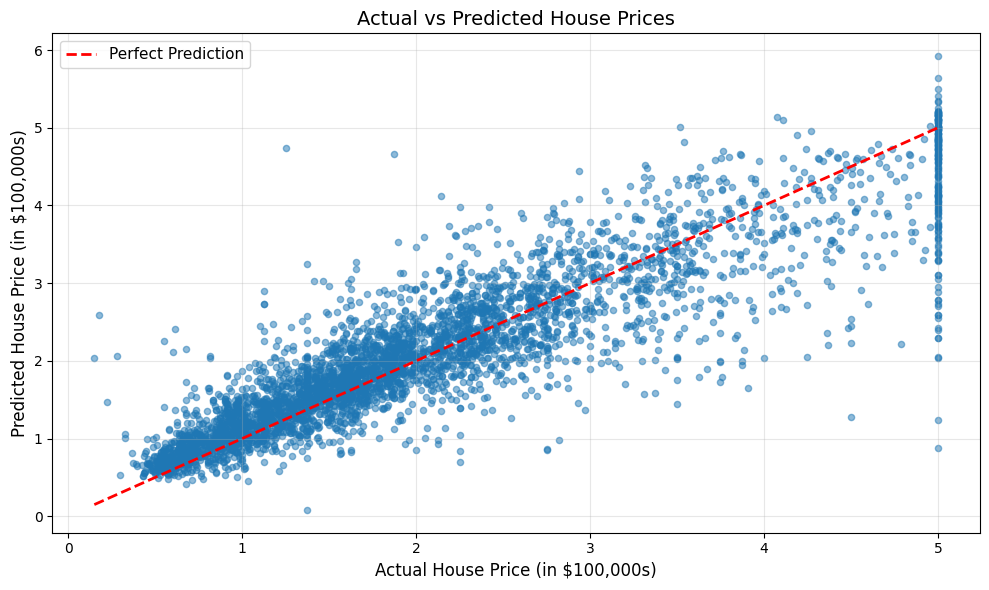


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$    47,700 | $    58,942 | $   -11,242
$    45,800 | $    73,624 | $   -27,824
$   500,001 | $   460,492 | $    39,509
$   218,600 | $   245,022 | $   -26,422
$   278,000 | $   292,612 | $   -14,612
$   158,700 | $   171,338 | $   -12,638
$   198,200 | $   235,478 | $   -37,278
$   157,500 | $   175,265 | $   -17,765
$   340,000 | $   236,978 | $   103,022
$   446,600 | $   466,467 | $   -19,867


In [ ]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")

In [ ]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


# Homework

In [ ]:
import zipfile
print("Imported zipfile module")

Imported zipfile module


In [ ]:
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
print("Extracted 'archive.zip' contents.")

Extracted 'archive.zip' contents.


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df_new = pd.read_csv('financial_regression.csv')

print("DataFrame loaded successfully. First 5 rows:")
print(df_new.head())

print("\nDataFrame Information:")
df_new.info()

print("\nDataFrame Descriptive Statistics:")
print(df_new.describe())

DataFrame loaded successfully. First 5 rows:
         date  sp500 open  sp500 high  sp500 low  sp500 close  sp500 volume  \
0  2010-01-14      114.49      115.14     114.42       114.93   115646960.0   
1  2010-01-15      114.73      114.84     113.20       113.64   212252769.0   
2  2010-01-18         NaN         NaN        NaN          NaN           NaN   
3  2010-01-19      113.62      115.13     113.59       115.06   138671890.0   
4  2010-01-20      114.28      114.45     112.98       113.89   216330645.0   

   sp500 high-low  nasdaq open  nasdaq high  nasdaq low  ...  palladium high  \
0            0.72        46.26       46.520       46.22  ...           45.02   
1            1.64        46.46       46.550       45.65  ...           45.76   
2             NaN          NaN          NaN         NaN  ...             NaN   
3            1.54        45.96       46.640       45.95  ...           47.08   
4            1.47        46.27       46.604       45.43  ...           47.31   


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Identify target variable
target_column = 'sp500 close'

# Identify columns to exclude from features
exclude_columns = ['date', 'us_rates_%', 'CPI', 'GDP', target_column]

# Select feature columns (all numeric columns not in exclude_columns)
feature_columns = [col for col in df_new.select_dtypes(include=np.number).columns if col not in exclude_columns]

# Create a new DataFrame with only selected features and target
df_processed = df_new[feature_columns + [target_column]].copy()

# Drop rows with any missing values in the selected columns
df_processed.dropna(inplace=True)

# Separate features (X) and target (y)
X = df_processed[feature_columns].values
y = df_processed[target_column].values

print(f"Original DataFrame shape: {df_new.shape}")
print(f"Processed DataFrame shape (after dropping NaNs): {df_processed.shape}")
print(f"Number of features (X): {X.shape[1]}")
print(f"Number of samples (y): {y.shape[0]}")
print(f"Selected Features: {feature_columns[:5]}... (and {len(feature_columns)-5} more)")
print(f"Target Variable: {target_column}")

Original DataFrame shape: (3904, 47)
Processed DataFrame shape (after dropping NaNs): (3677, 43)
Number of features (X): 42
Number of samples (y): 3677
Selected Features: ['sp500 open', 'sp500 high', 'sp500 low', 'sp500 volume', 'sp500 high-low']... (and 37 more)
Target Variable: sp500 close


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Training set size: 2941 samples
Test set size: 736 samples

✓ Data normalized (mean=0, std=1)

Batch size: 64
Number of training batches: 46
Number of test batches: 12


In [ ]:
import torch.nn as nn
import torch.optim as optim

# 1. Determine the input_size for the RegressionModel
input_size = X_train_scaled.shape[1]  # Number of features

# 2. Re-initialize the RegressionModel
# Use the existing RegressionModel class definition from previous cells
model = RegressionModel(input_size).to(device)

print(f"New model initialized with input size: {input_size}")
print(f"Model moved to: {device}")

# 3. Re-initialize the Loss function: Mean Squared Error
criterion = nn.MSELoss()

# 4. Re-initialize the Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

# 5. Training parameters and loss tracking
num_epochs = 100

train_losses = []
test_losses = []

print("\nStarting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # 6. Training phase
    model.train()  # Set model to training mode
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 7. Evaluation phase (no gradient computation needed)
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

New model initialized with input size: 42
Model moved to: cuda
Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 1324.6644 | Test Loss: 1355.0234
Epoch [20/100] | Train Loss: 734.9869 | Test Loss: 781.0298
Epoch [30/100] | Train Loss: 534.7441 | Test Loss: 581.5241
Epoch [40/100] | Train Loss: 435.7614 | Test Loss: 475.0346
Epoch [50/100] | Train Loss: 376.3885 | Test Loss: 421.7773
Epoch [60/100] | Train Loss: 322.3949 | Test Loss: 359.4235
Epoch [70/100] | Train Loss: 274.1469 | Test Loss: 305.9909
Epoch [80/100] | Train Loss: 230.3376 | Test Loss: 265.8745
Epoch [90/100] | Train Loss: 184.5765 | Test Loss: 208.2886
Epoch [100/100] | Train Loss: 138.7873 | Test Loss: 175.5189
------------------------------------------------------------
Training complete!


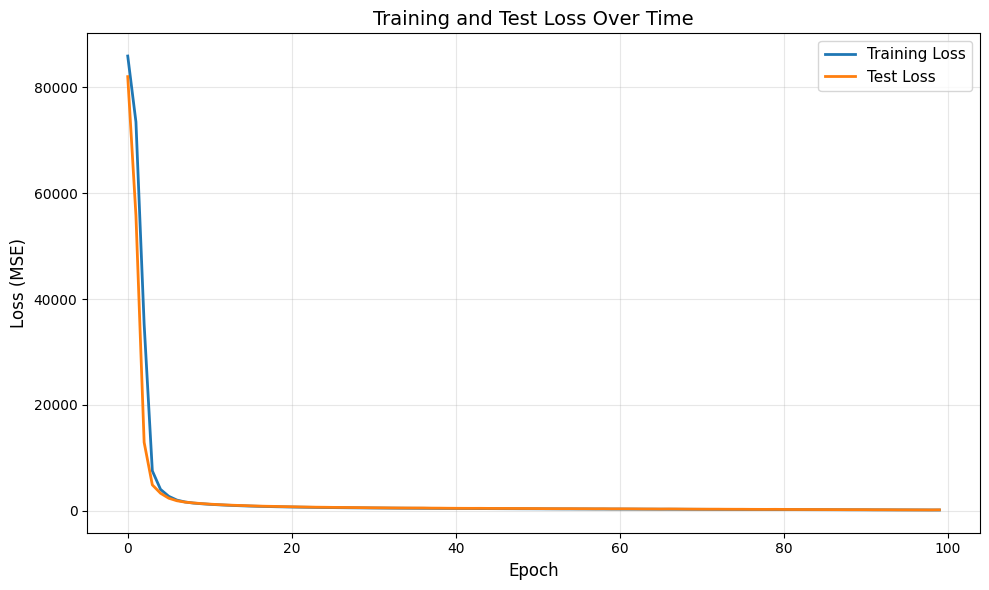

Final Training Loss: 138.7873
Final Test Loss: 175.5189


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  175.1611
Root Mean Squared Error (RMSE): 13.2348
Mean Absolute Error (MAE): 10.4478
R² Score: 0.9888

Interpretation:
On average, predictions are off by $1044780.25
Model explains 98.88% of the variance in house prices


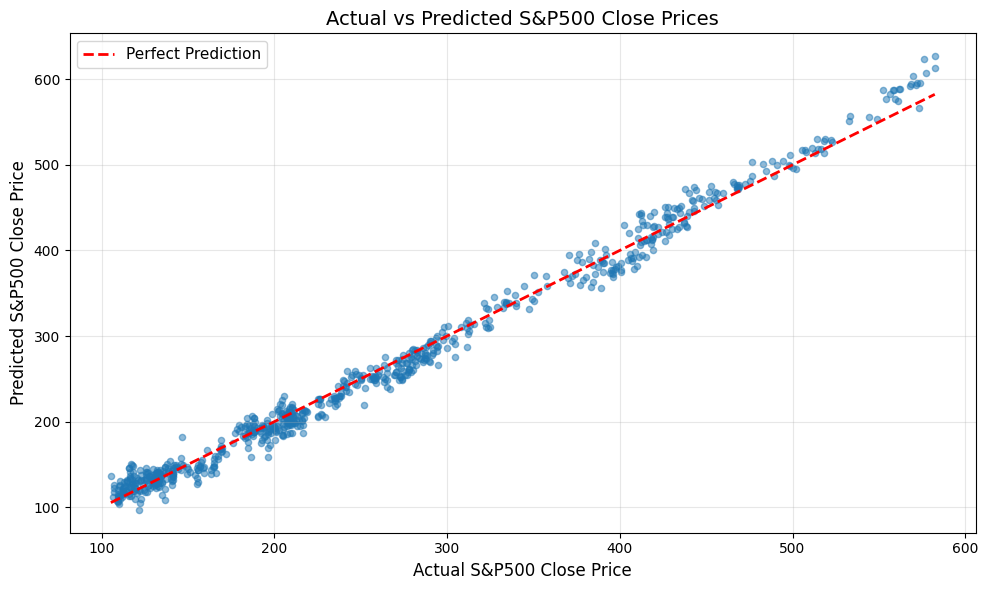


Sample Predictions (first 10 prices):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
      281.42 |       270.34 |        11.08
      227.10 |       219.78 |         7.32
      572.30 |       595.85 |       -23.55
      414.92 |       411.81 |         3.11
      214.89 |       194.77 |        20.12
      132.47 |       139.90 |        -7.43
      290.27 |       269.72 |        20.55
      439.92 |       467.65 |       -27.73
      279.52 |       273.49 |         6.03
      124.67 |       120.13 |         4.54


In [ ]:
import matplotlib.pyplot as plt

# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual S&P500 Close Price', fontsize=12)
plt.ylabel('Predicted S&P500 Close Price', fontsize=12)
plt.title('Actual vs Predicted S&P500 Close Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 prices):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0]
    predicted = y_pred[i][0]
    diff = actual - predicted
    print(f"{actual:>12.2f} | {predicted:>12.2f} | {diff:>12.2f}")

In [ ]:
import torch

# Save model's state_dict
torch.save(model.state_dict(), 'financial_regression_model.pth')
print("✓ Model saved to 'financial_regression_model.pth'")

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('financial_regression_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'financial_regression_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('financial_regression_model.pth'))
  model.to(device)
  model.eval()
